# Loading data and $0^{\text{th}}$ order EDA

In [4]:
# Load the required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [17]:
# Read the original file
original_path = 'data/original.xlsx'
orig_xls = pd.ExcelFile(original_path)
print(orig_xls.sheet_names)

['Training_set_Staphiloccocus', 'Test_set_Staphiloccocus']


In [18]:
# import the excel sheets separately
df1 = orig_xls.parse('Training_set_Staphiloccocus')
df2 = orig_xls.parse('Test_set_Staphiloccocus')

In [19]:
# import the extra data that we have
additional_path = 'data/additional.xlsx'
addit_xls = pd.ExcelFile(additional_path)
print(addit_xls.sheet_names)

['Sheet1', 'Sheet2']


In [20]:
# there is one more column -- 'Sequence', that we remove to match the rest of the data
df3 = addit_xls.parse('Sheet1').drop(['Sequence'], axis=1)

In [21]:
print(df1.shape, df2.shape, df3.shape)

(298, 13) (74, 13) (52, 13)


In [22]:
# merge the three excel sheets into the training + validation data + test
df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Normalized Hydrophobic Moment                424 non-null    float64
 1   Normalized Hydrophobicity                    424 non-null    float64
 2   Net Charge                                   424 non-null    int64  
 3   Isoelectric Point                            424 non-null    float64
 4   Penetration Depth                            424 non-null    int64  
 5   Tilt Angle                                   424 non-null    int64  
 6   Propensity to Disordering                    424 non-null    float64
 7   Linear Moment                                424 non-null    float64
 8   Propensity to in vitro Aggregation           424 non-null    float64
 9   Angle Subtended by the Hydrophobic Residues  424 non-null    int64  
 10  Am

In [23]:
df.head(5)

,Normalized Hydrophobic Moment,Normalized Hydrophobicity,Net Charge,Isoelectric Point,Penetration Depth,Tilt Angle,Propensity to Disordering,Linear Moment,Propensity to in vitro Aggregation,Angle Subtended by the Hydrophobic Residues,Amphiphilicity Index,Propensity to Coil Conformation,Class
0,0.42086,0.91583,4,12.10504,13,96,-0.34970,0.42556,0.0000,70,2.97083,1.04917,1
1,0.37036,1.10727,-1,5.25003,18,103,0.11861,0.36594,0.0000,70,1.04545,0.96273,0
2,0.64232,0.94500,-1,4.16000,14,69,0.37261,0.26041,0.0000,130,0.62429,0.88429,0
3,0.44110,0.28308,2,14.00000,11,87,0.51687,0.38844,13.1668,100,1.34846,0.91385,1
4,0.22350,1.09727,1,9.86007,18,81,0.01275,0.49684,0.0000,70,0.67000,1.00818,0


### $\color{red}{\textbf{Correlations bewteen features}}$

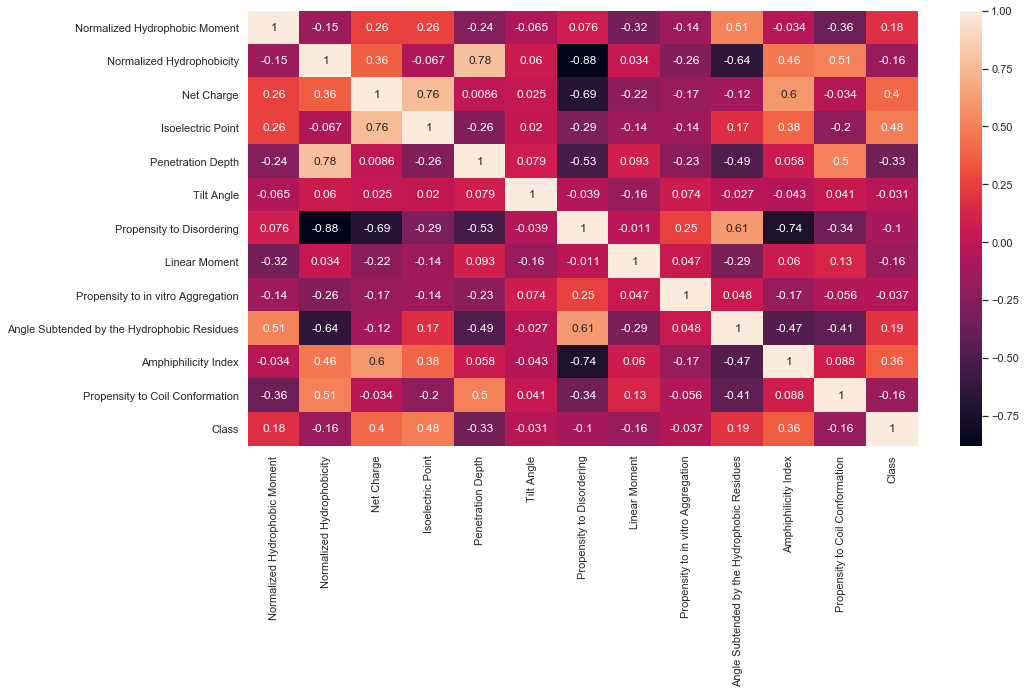

In [24]:
# Correlation matrix 
plt.figure(figsize=(15,8))
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True)

In [25]:
# The strongest correlation is between 'Propensity to Disordering' and 'Normalized Hydrophobicity'
unwrapped = np.abs(corr_mat.values.reshape((1,-1)))
max_abs_cor = unwrapped[unwrapped < 1].max()
print(max_abs_cor)

0.8798900532752945


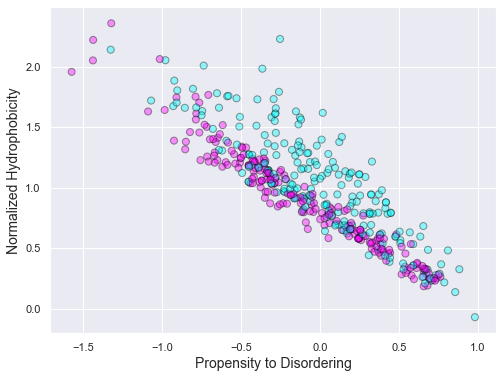

In [26]:
# Let us plot these two features
plt.scatter(df['Propensity to Disordering'], df['Normalized Hydrophobicity'], c=df['Class'], marker='o', 
            s=50, alpha=.4, cmap='cool', edgecolor='black')
plt.xlabel('Propensity to Disordering', fontsize = 14)
plt.ylabel('Normalized Hydrophobicity', fontsize = 14)
plt.show()

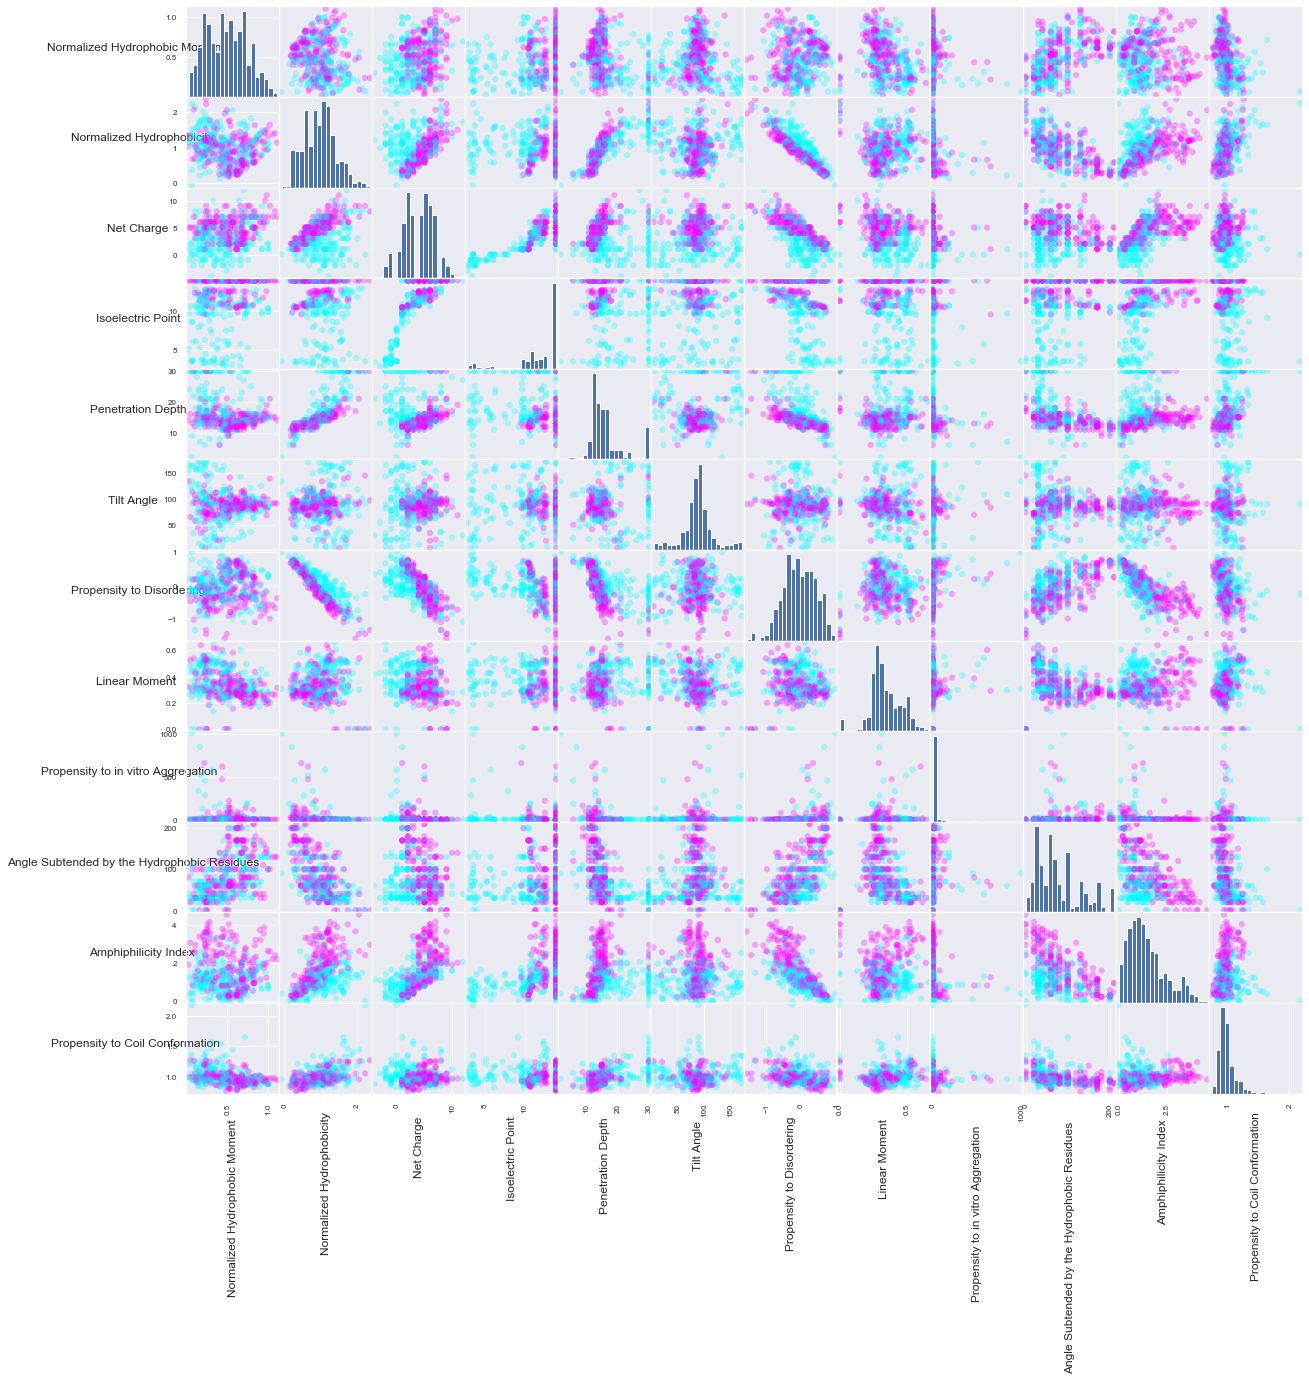

In [27]:
# Plot the full scatter matrix
data_sm = pd.plotting.scatter_matrix(df.drop(['Class'],axis=1),c=df['Class'], figsize=(20, 20), marker='o',
                            hist_kwds={'bins': 20}, s=40, alpha=.3, cmap='cool')
n = len(df.drop(['Class'],axis=1).columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = data_sm[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 30

### $\color{red}{\textbf{PCA}}$

In [28]:
# Let's check if one can reduce dimensionality. For PCA to make sense, standardize data!
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

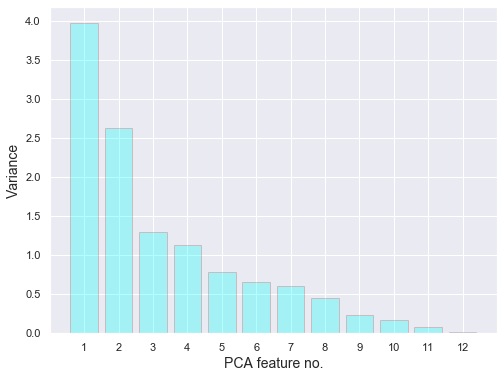

In [29]:
pca_transformer = PCA()
stdzed_raw_data = StandardScaler().fit_transform(df.drop(['Class'], axis=1).values)
pca_transformer.fit(stdzed_raw_data)
pca_feat_matrix = pca_transformer.transform(stdzed_raw_data)
features = range(1, pca_transformer.n_components_ + 1)
plt.bar(features, pca_transformer.explained_variance_, color='cyan', edgecolor='r', alpha=0.3)
plt.xticks(features)
plt.xlabel('PCA feature no.', fontsize = 14)
plt.ylabel('Variance', fontsize = 14)
plt.show()

In [30]:
# The data is NOT lower-dimensional, but let's anyway check if the 2-component PCA would separate classes

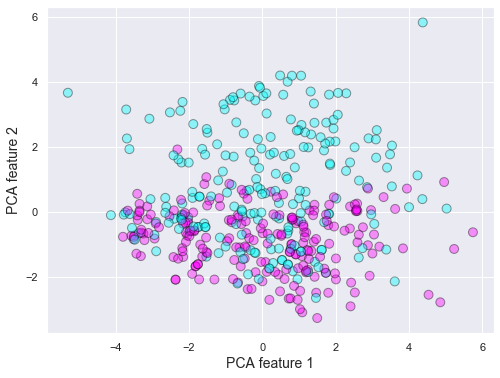

In [31]:
pca_transformer = PCA(n_components=2)
stdzed_raw_data = StandardScaler().fit_transform(df.drop(['Class'], axis=1).values)
pca_transformer.fit(stdzed_raw_data)
pca_feat_matrix = pca_transformer.transform(stdzed_raw_data)
features = range(1, pca_transformer.n_components_ + 1)
plt.scatter(pca_feat_matrix[:,0], pca_feat_matrix[:,1], c=df['Class'], marker='o', 
            s=80, alpha=.4, cmap='cool', edgecolor='black')
plt.xlabel('PCA feature 1', fontsize=14)
plt.ylabel('PCA feature 2', fontsize =14)
plt.show()

In [32]:
# Not really. Let's move on.

# Fitting and predicting

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split

In [34]:
# split into features and labels (and transform to np arrays)
X = df.drop(['Class'], axis=1).values
y = df['Class'].values
print(X.shape, y.shape)

(424, 12) (424,)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### $\color{red}{\textbf{SVM}}$

#### In this first version, we will not touch the $\gamma$ parameter and change kernel; 'rbf' seems to work best

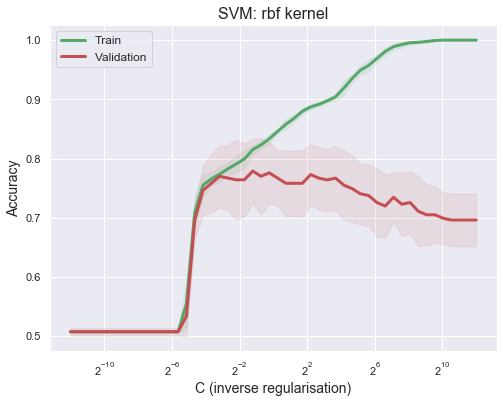

In [45]:
def SVMPredict(kernel, C, X, y):
    clf = make_pipeline(StandardScaler(), svm.SVC(kernel=kernel, C=C))
    scores = cross_validate(clf, X, y, cv=5, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

######### CHOOSE ADDITIONAL PARAMETERS HERE

kernel = 'rbf' 

######### CHOOSE ADDITIONAL PARAMETERS HERE

C_list = np.logspace(-12, 12, base = 2.)
train_accuracies = np.asarray([SVMPredict(kernel, C, X_train, y_train)['train_mean'] for C in C_list])
train_stds = np.asarray([SVMPredict(kernel, C, X_train, y_train)['train_std'] for C in C_list])
plt.plot(C_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(C_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
valid_accuracies = np.asarray([SVMPredict(kernel, C, X_train, y_train)['test_mean'] for C in C_list])
valid_stds = np.asarray([SVMPredict(kernel, C, X_train, y_train)['test_std'] for C in C_list])
plt.plot(C_list, valid_accuracies, 'r', linewidth = 3)
plt.xscale('log', basex=2)
plt.fill_between(C_list, valid_accuracies - valid_stds, valid_accuracies + valid_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Validation'), fontsize = 12)
plt.title('SVM: rbf kernel', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('C (inverse regularisation)', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [49]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = svm.SVC(kernel=kernel, C=4)
clf.fit(X_train_scaled, y_train)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.8

In [ ]:
################CHANGE FROM HERE TO THE END#########################################################

### $\color{red}{\textbf{k nearest neighbours}}$

#### Accuracy vs k for uniform and dustance kNN

In [75]:
# define a function that performs CV together with normalisation of data and plots accuracy vs k

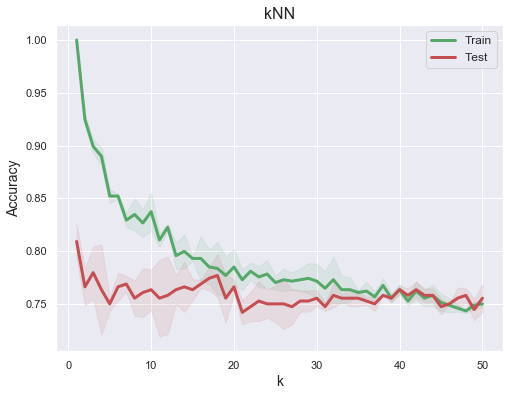

In [76]:
def kNNpredict_uniform(k, X, y):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k, weights='uniform'))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

k_list = np.asarray([*range(1, 51)])
train_accuracies = np.asarray([kNNpredict_uniform(k, X, y)['train_mean'] for k in k_list])
train_stds = np.asarray([kNNpredict_uniform(k, X, y)['train_std'] for k in k_list])
plt.plot(k_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(k_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([kNNpredict_uniform(k, X, y)['test_mean'] for k in k_list])
test_stds = np.asarray([kNNpredict_uniform(k, X, y)['test_std'] for k in k_list])
plt.plot(k_list, test_accuracies, 'r', linewidth = 3)
plt.fill_between(k_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('kNN', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('k', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [77]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = KNeighborsClassifier(n_neighbors=8, weights='uniform')
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6538461538461539

### $\color{red}{\textbf{Decision trees}}$

In [78]:
# Trees do not generally require standardisation of data, so we will no include the latter

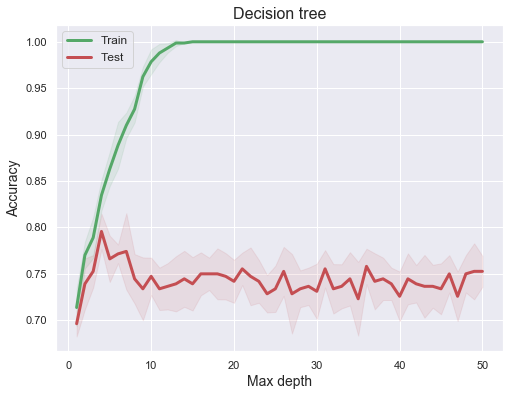

In [79]:
def TreePredict(depth, X, y):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

depth_list = np.asarray([*range(1, 51)])
train_accuracies = np.asarray([TreePredict(depth, X, y)['train_mean'] for depth in depth_list])
train_stds = np.asarray([TreePredict(depth, X, y)['train_std'] for depth in depth_list])
plt.plot(depth_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(depth_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([TreePredict(depth, X, y)['test_mean'] for depth in depth_list])
test_stds = np.asarray([TreePredict(depth, X, y)['test_std'] for depth in depth_list])
plt.plot(depth_list, test_accuracies, 'r', linewidth = 3)
plt.fill_between(depth_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('Decision tree', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Max depth', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [80]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6346153846153846

### $\color{red}{\textbf{Logistic regression}}$


In [81]:
# Let us try logreg both with and without data standardization. First standardise

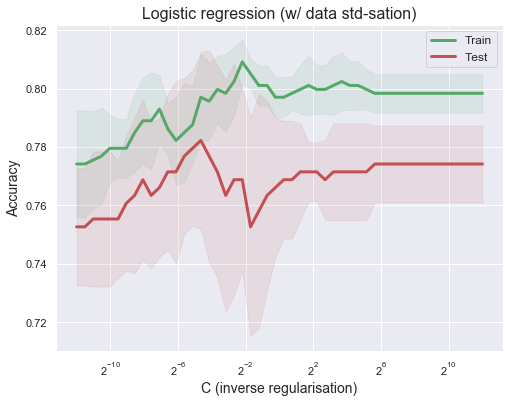

In [82]:
def LogRegPredict(C, X, y):
    clf = make_pipeline(StandardScaler(), LogisticRegression(C=C, solver='liblinear'))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

C_list = np.logspace(-12, 12, base = 2.)
train_accuracies = np.asarray([LogRegPredict(C, X, y)['train_mean'] for C in C_list])
train_stds = np.asarray([LogRegPredict(C, X, y)['train_std'] for C in C_list])
plt.plot(C_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(C_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([LogRegPredict(C, X, y)['test_mean'] for C in C_list])
test_stds = np.asarray([LogRegPredict(C, X, y)['test_std'] for C in C_list])
plt.plot(C_list, test_accuracies, 'r', linewidth = 3)
plt.xscale('log', basex=2)
plt.fill_between(C_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('Logistic regression (w/ data std-sation)', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('C (inverse regularisation)', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [84]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = LogisticRegression(C=1, solver='liblinear')
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6346153846153846